# Analyze growth rates

In [1]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [2]:
from coralme.builder.main import MEBuilder, MEReconstruction, METroubleshooter
from coralme.builder.curation import MECurator, MEManualCuration
from coralme.builder.helper_functions import flux_based_reactions,exchange_single_model
import coralme
import pickle
import pandas
import os
import tqdm
import numpy
import json
pandas.set_option('display.max_colwidth', None)
from coralme.builder.helper_functions import *
import matplotlib.pyplot as plt

## Analyze

In [3]:
with open('names.json') as f:
    names = json.load(f)

### Load models

In [4]:
def load_me(filename='me_model.pickle'):
    with open(filename, "rb") as f:
        return pickle.load(f)
    
def get_org_dirs(directory,files=False):
    if files:
        return [i for i in os.listdir(directory) if '.pkl' in i]
    return [i for i in os.listdir(directory) if os.path.isdir(directory+i) and '.' not in i and '_' not in i]

def run(i,directory,files=False,step=2,solve=False):
    if files:
        modelpath = directory + i
    elif step == 2:
        modelpath = directory + '{}/MEModel-step2-{}.pkl'.format(i,i)
    elif step == 3:
        modelpath = directory + '{}/MEModel-step3-{}-TS.pkl'.format(i,i)
    model = load_me(modelpath)
    if solve:
        model.optimize()
    return i.split(".pkl")[0], model

def load_models_from_directory(directory,solve=False, step = 2, files=False):
    d = {}
    dirs = get_org_dirs(directory,files=files)
    for org in tqdm.tqdm(dirs):
        args = [org,directory]
        kwds = {'files' : files, 'step' : step, 'solve' : solve}
        i,model = run(*args,**kwds)
        d[i] = model
    return d

In [5]:
models = {
    'clean':load_models_from_directory('./clean/',step=3)
         }

  0%|          | 0/21 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-16
Read LP format model from file /tmp/tmp0k96bo6n.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpxnvrc_bf.lp
Reading time = 0.00 seconds
: 952 rows, 2150 columns, 10008 nonzeros
Read LP format model from file /tmp/tmpj6s75kon.lp
Reading time = 0.00 seconds
: 957 rows, 2144 columns, 9760 nonzeros


  5%|▍         | 1/21 [00:02<00:58,  2.92s/it]

Read LP format model from file /tmp/tmpeh7i32o0.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpq8uvao_f.lp
Reading time = 0.00 seconds
: 303 rows, 636 columns, 2922 nonzeros
Read LP format model from file /tmp/tmp2vf3ha_z.lp
Reading time = 0.00 seconds
: 303 rows, 632 columns, 2910 nonzeros


 10%|▉         | 2/21 [00:03<00:28,  1.53s/it]

Read LP format model from file /tmp/tmppkzhya_5.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpel_weo84.lp
Reading time = 0.01 seconds
: 1802 rows, 5090 columns, 19612 nonzeros
Read LP format model from file /tmp/tmpor4qb0us.lp
Reading time = 0.01 seconds
: 1817 rows, 5084 columns, 19460 nonzeros


 14%|█▍        | 3/21 [00:09<01:01,  3.39s/it]

Read LP format model from file /tmp/tmp4zad8115.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpal1xmym8.lp
Reading time = 0.00 seconds
: 888 rows, 2030 columns, 8878 nonzeros
Read LP format model from file /tmp/tmpwsqnluhg.lp
Reading time = 0.00 seconds
: 952 rows, 2024 columns, 8836 nonzeros


 19%|█▉        | 4/21 [00:12<00:56,  3.34s/it]

Read LP format model from file /tmp/tmpsjrw1usc.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp3eisijhx.lp
Reading time = 0.01 seconds
: 1914 rows, 5238 columns, 19960 nonzeros
Read LP format model from file /tmp/tmp60u40bc1.lp
Reading time = 0.01 seconds
: 1912 rows, 5232 columns, 19796 nonzeros


 24%|██▍       | 5/21 [00:18<01:08,  4.27s/it]

Read LP format model from file /tmp/tmp3efyxdyb.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp6okq8r36.lp
Reading time = 0.00 seconds
: 768 rows, 1698 columns, 7642 nonzeros
Read LP format model from file /tmp/tmpcks7y_km.lp
Reading time = 0.00 seconds
: 787 rows, 1692 columns, 7596 nonzeros


 29%|██▊       | 6/21 [00:20<00:51,  3.45s/it]

Read LP format model from file /tmp/tmpekw7b7fh.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpvnkzy1e1.lp
Reading time = 0.00 seconds
: 998 rows, 2452 columns, 11474 nonzeros
Read LP format model from file /tmp/tmp5oggiw75.lp
Reading time = 0.00 seconds
: 999 rows, 2448 columns, 11252 nonzeros


 33%|███▎      | 7/21 [00:23<00:49,  3.55s/it]

Read LP format model from file /tmp/tmporle0dah.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpknge4_9j.lp
Reading time = 0.00 seconds
: 1741 rows, 4344 columns, 15936 nonzeros
Read LP format model from file /tmp/tmpb0u3ehp5.lp
Reading time = 0.00 seconds
: 1739 rows, 4340 columns, 15792 nonzeros


 38%|███▊      | 8/21 [00:28<00:51,  3.99s/it]

Read LP format model from file /tmp/tmpc5f0y6tc.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpp604uxo7.lp
Reading time = 0.00 seconds
: 649 rows, 1508 columns, 6436 nonzeros
Read LP format model from file /tmp/tmpn9y36xd7.lp
Reading time = 0.00 seconds
: 651 rows, 1504 columns, 6386 nonzeros


 43%|████▎     | 9/21 [00:31<00:44,  3.72s/it]

Read LP format model from file /tmp/tmpig0eomx_.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp4kbk5kss.lp
Reading time = 0.00 seconds
: 571 rows, 1304 columns, 5688 nonzeros
Read LP format model from file /tmp/tmpj8q25zsf.lp
Reading time = 0.00 seconds
: 618 rows, 1300 columns, 5572 nonzeros


 48%|████▊     | 10/21 [00:33<00:32,  2.98s/it]

Read LP format model from file /tmp/tmprvpa0nxg.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpdwmxrs3q.lp
Reading time = 0.00 seconds
: 887 rows, 1784 columns, 7394 nonzeros
Read LP format model from file /tmp/tmp165s_7q2.lp
Reading time = 0.00 seconds
: 892 rows, 1778 columns, 7256 nonzeros


 52%|█████▏    | 11/21 [00:35<00:26,  2.61s/it]

Read LP format model from file /tmp/tmptl_whr34.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpkyazhdn5.lp
Reading time = 0.01 seconds
: 2153 rows, 5854 columns, 23272 nonzeros
Read LP format model from file /tmp/tmpjgfijce7.lp
Reading time = 0.01 seconds
: 2153 rows, 5848 columns, 23040 nonzeros


 57%|█████▋    | 12/21 [00:41<00:35,  3.92s/it]

Read LP format model from file /tmp/tmpmb1asu68.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpa5izdupd.lp
Reading time = 0.01 seconds
: 1805 rows, 5166 columns, 20366 nonzeros
Read LP format model from file /tmp/tmpmwt8vplw.lp
Reading time = 0.01 seconds
: 1805 rows, 5160 columns, 20202 nonzeros


 62%|██████▏   | 13/21 [00:48<00:37,  4.68s/it]

Read LP format model from file /tmp/tmpsibjkq4q.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp7h4jdlqe.lp
Reading time = 0.00 seconds
: 1552 rows, 3922 columns, 14998 nonzeros
Read LP format model from file /tmp/tmp5ebaynz8.lp
Reading time = 0.00 seconds
: 1566 rows, 3918 columns, 14868 nonzeros


 67%|██████▋   | 14/21 [00:53<00:34,  4.94s/it]

Read LP format model from file /tmp/tmppjd1jis7.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp1f7qbe8e.lp
Reading time = 0.00 seconds
: 718 rows, 1632 columns, 7016 nonzeros
Read LP format model from file /tmp/tmpq6r0_nsm.lp
Reading time = 0.00 seconds
: 729 rows, 1628 columns, 6842 nonzeros


 71%|███████▏  | 15/21 [00:55<00:23,  3.94s/it]

Read LP format model from file /tmp/tmpeygqk5de.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpspfnuhje.lp
Reading time = 0.00 seconds
: 1114 rows, 2298 columns, 10154 nonzeros
Read LP format model from file /tmp/tmpr6cb60rl.lp
Reading time = 0.00 seconds
: 1116 rows, 2292 columns, 9972 nonzeros


 76%|███████▌  | 16/21 [00:57<00:16,  3.38s/it]

Read LP format model from file /tmp/tmplmzripov.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpihj5xv00.lp
Reading time = 0.00 seconds
: 884 rows, 2458 columns, 10468 nonzeros
Read LP format model from file /tmp/tmps71f_zwj.lp
Reading time = 0.00 seconds
: 946 rows, 2452 columns, 10428 nonzeros


 81%|████████  | 17/21 [01:02<00:15,  3.94s/it]

Read LP format model from file /tmp/tmp4txbq4qt.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp7jh2w19d.lp
Reading time = 0.00 seconds
: 485 rows, 1108 columns, 4628 nonzeros
Read LP format model from file /tmp/tmpnngcciif.lp
Reading time = 0.00 seconds
: 539 rows, 1106 columns, 4516 nonzeros


 86%|████████▌ | 18/21 [01:03<00:09,  3.06s/it]

Read LP format model from file /tmp/tmpg37xbald.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpi42fumyi.lp
Reading time = 0.00 seconds
: 1335 rows, 2910 columns, 12048 nonzeros
Read LP format model from file /tmp/tmpu8hm27st.lp
Reading time = 0.00 seconds
: 1369 rows, 2906 columns, 12024 nonzeros


 90%|█████████ | 19/21 [01:06<00:05,  2.97s/it]

Read LP format model from file /tmp/tmp0qfb1ojw.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmp9uoazxii.lp
Reading time = 0.00 seconds
: 990 rows, 2500 columns, 10478 nonzeros
Read LP format model from file /tmp/tmpluyomtpx.lp
Reading time = 0.00 seconds
: 1055 rows, 2496 columns, 10342 nonzeros


 95%|█████████▌| 20/21 [01:09<00:02,  2.81s/it]

Read LP format model from file /tmp/tmpg9ur_xcm.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpl8kz4h1d.lp
Reading time = 0.00 seconds
: 1109 rows, 2570 columns, 11714 nonzeros
Read LP format model from file /tmp/tmpv0cnnnnb.lp
Reading time = 0.00 seconds
: 1111 rows, 2564 columns, 11682 nonzeros


100%|██████████| 21/21 [01:15<00:00,  3.60s/it]


### Load simulations

In [6]:
results_dict = {}
directory = "./analysis/10steps/"
for file in os.listdir(directory):
    if ".csv" not in file: continue
    results_dict[file.split("_C_uptake")[0]] = pandas.read_csv(directory + file,index_col=0)

results_dict = {names[k]:v for k,v in results_dict.items()}

### Calculate overflow

In [7]:
def get_exchange(reactions,flux_dict):
    l = []
    for r in reactions:
        if flux_dict[r.id] <= 0:
            continue
        met = next(i for i in r.reactants)
        if "C" not in met.elements:
            continue
        l.append(r)
    return l

In [8]:
def get_overflow(org):
    model = models['clean'][org]
    df = results_dict[names[org]]
    # Only exchange
    df = df[df.index.str.contains("^EX_|^TS_")]
    # Only secretion
    df = df[df>1e-6].fillna(0)
    
    df = df.loc[[i for i in df.index if hasattr(model.reactions,i)]]

    # To C-mole
    mets = [next(i for i in model.get(r).reactants) for r in df.index]
    carbons = [i.elements.get("C",0) for i in mets]
    df = (df.T * carbons).T
    # Only active
    df = df[df>1e-3].fillna(0.)
    df = df[df.any(axis=1)]
    # Not co2
    df = df[~df.index.str.contains("co2_e")]
    return df

def get_normalized_overflow(org):
    df = get_overflow(org)
    df = df[df.index.str.contains("EX_")]
    df = df/df.sum().max()
    return df 

def plot(org, ax=None, legend = True):
    # Normalize
    df = get_normalized_overflow(org)
    # Re order
    df = df.loc[[i for i in df.mean(axis=1).sort_values(ascending=True).index]]
    # Plot
    if df.empty:
        return
    df.T.plot.area(ax=ax)
    df.sum().plot(ax=ax,style='o',color='gray',alpha=0.4)

    ax.legend(loc=2, prop={'size': 6})
    ax.set_xticks(range(df.shape[1]))
    ax.set_xticklabels(["{:.1f}".format(i) for i in numpy.arange(0.1,1.5,0.1)])
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    if not legend:
        ax.get_legend().remove()

## Examples

### _P. putida_

https://microbialcellfactories.biomedcentral.com/articles/10.1186/1475-2859-10-25

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3107774/

### _S. aureus_

https://journals.asm.org/doi/10.1128/mbio.01434-16

### _L. cremoris_

2h3mb_e overflow because of acetolactate overflow 

https://journals.plos.org/plospathogens/article?id=10.1371/journal.ppat.1004205

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8148554/

2hxic__L_e overflow 

https://www.nature.com/articles/s41598-017-10948-0

4abut_c secreted for glutamate uptake

https://www.sciencedirect.com/science/article/pii/S1369703X20300401

ethanol, lactate, acetate and formate

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC94391/

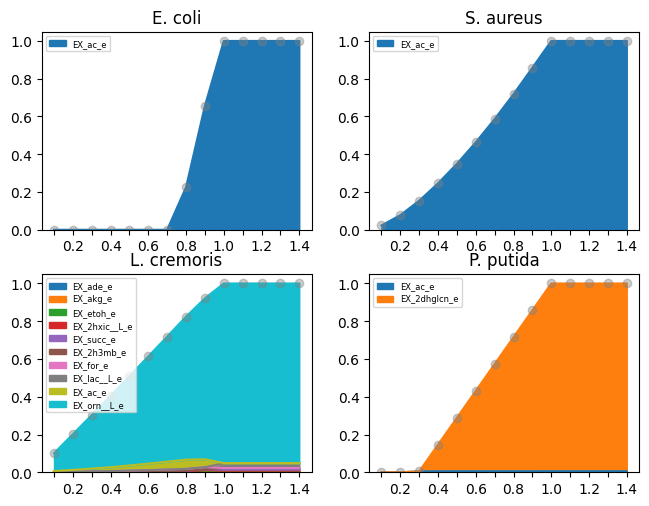

In [9]:
ex = ['ecoli','saureus','lcremoris','pputida']
fig,ax = plt.subplots(2,2,figsize = (5*1.34,5))
ax = ax.flatten()
plt.tight_layout()
for idx,org in enumerate(ex):
    plot(org,ax=ax[idx])
    ax[idx].set_title(names[org])
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("./figures/carbon_overflow_examples.svg",format="SVG")

## All

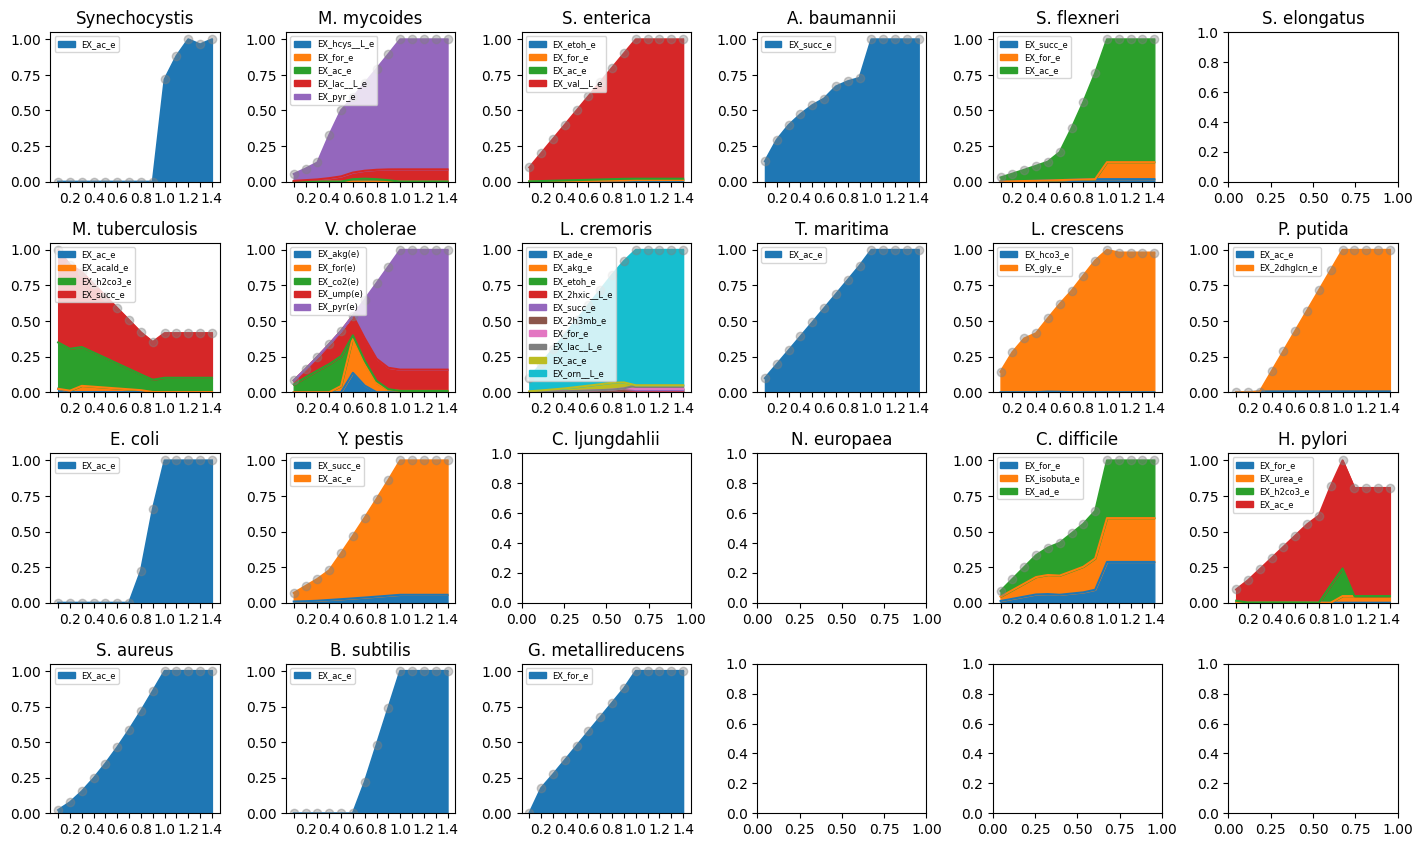

In [10]:
ex = list(models['clean'].keys())
fig,ax = plt.subplots(4,6,figsize = (20/1.4,12/1.4))
ax = ax.flatten()
for idx,org in enumerate(ex):
    plot(org,ax=ax[idx],legend=True)
    ax[idx].set_title(names[org])
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("./figures/carbon_overflow_all.svg",format="SVG")

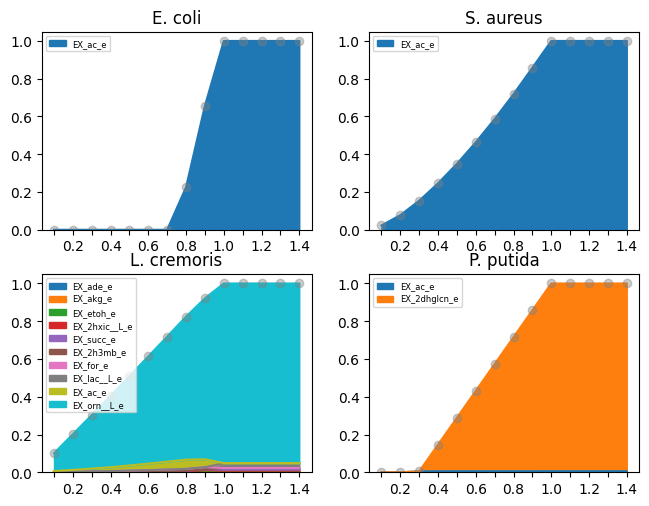

In [11]:
ex = ['ecoli','saureus','lcremoris','pputida']
fig,ax = plt.subplots(2,2,figsize = (5*1.34,5))
ax = ax.flatten()
plt.tight_layout()
for idx,org in enumerate(ex):
    plot(org,ax=ax[idx])
    ax[idx].set_title(names[org])
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig("./figures/carbon_overflow_examples.svg",format="SVG")